# Detrending Climate Model Data 

### Authors

Fletcher Hozven fhozven@ucsb.edu

### Table of Contents

- **Introduction**
- **What is a Trend and Why Detrend?**
- **Load CESM2 Ensemble Data**
- **Select Time Period and Annual Mean**
- **Detrending**
- **Compare Trended vs. Detrended**


### __Introduction__

In this tutorial, we'll are using surface air temperature data from different CESM2 ensemble members from CMIP6 to detrend the ensemble and remove the global warming signal and focus on internal variability.


### __What is a Trend and Why Detrend?__

__A trend is a long-term change in a dataset.__ For example, increasing global temperatures over decades
due to climate change is an upward trend or in this plot example a decrease in soil moisture.

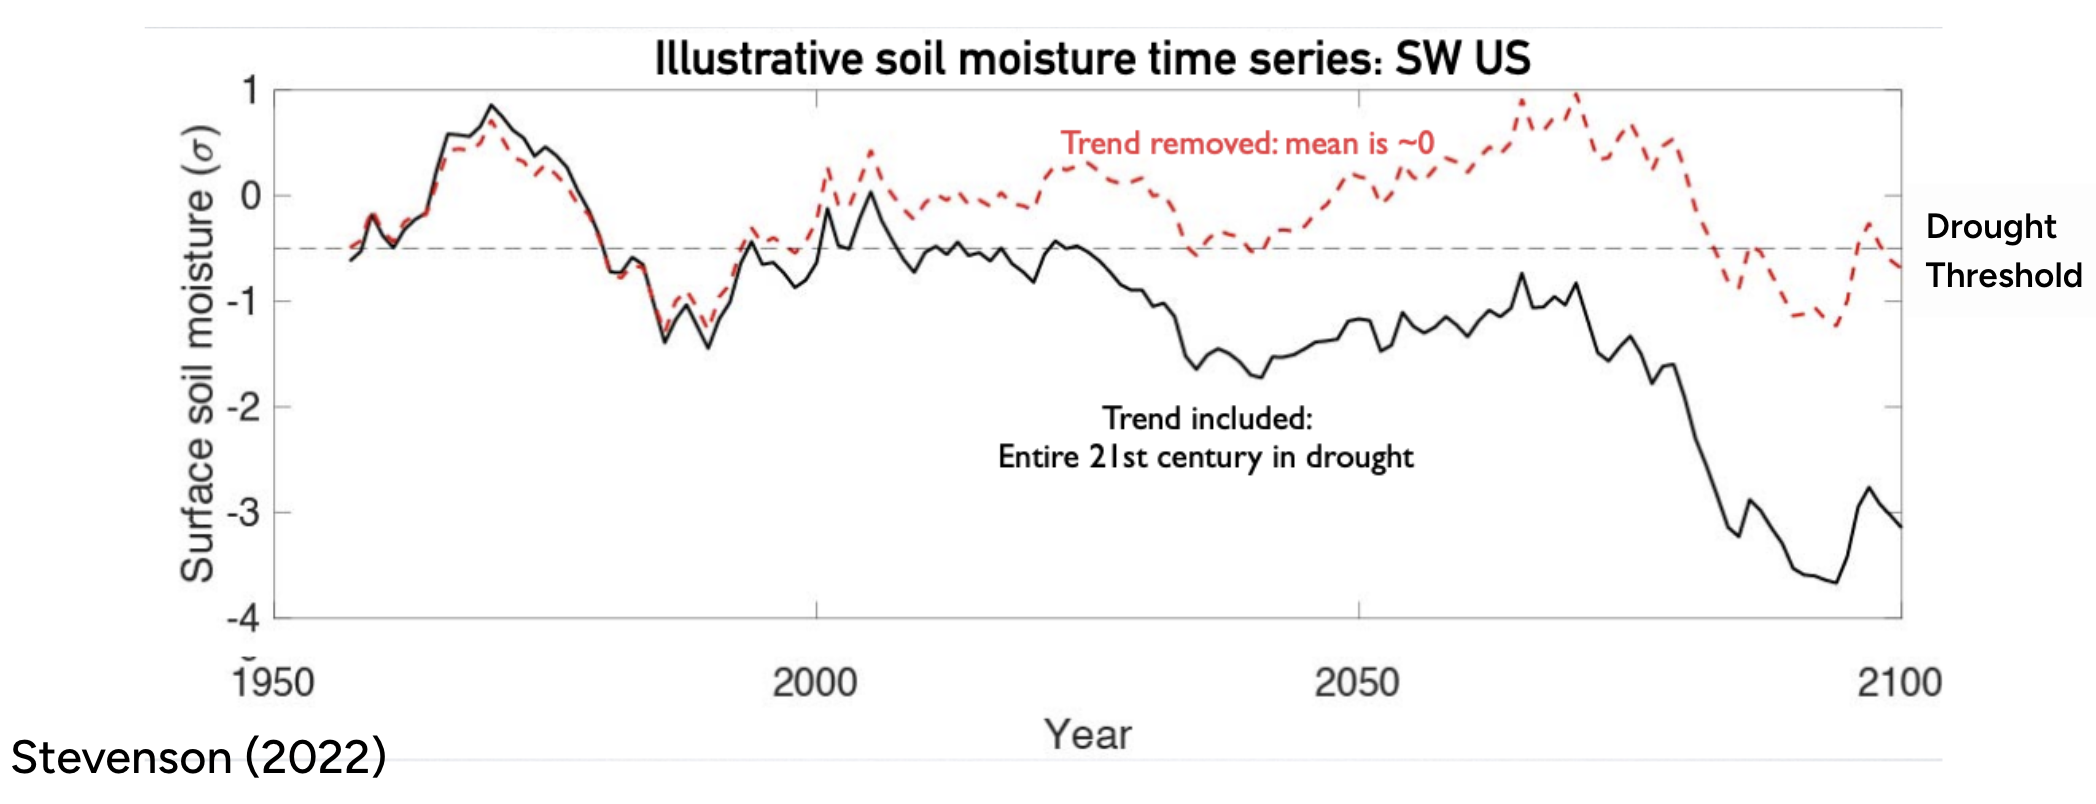

Detrending removes this shared signal across ensemble members so we can isolate natural year-to-year variability. 

This is useful for:
- Detecting anomalies
- Studying climate variability independent of warming
- Comparing regional and member-specific differences


### __Load CESM2 Ensemble Data from __CMIP6

In [179]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

Open CMIP6 catalog

In [181]:
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

Search for CESM2, tas, historical experiment

In [183]:

query = catalog.search(
    source_id=['CESM2'],
    experiment_id=['historical'],
    table_id='Amon',
    variable_id='tas',
    activity_id='CMIP'
)


Look at all the available ensemble members

In [185]:
display(query.df[['member_id', 'zstore']])

,member_id,zstore
0,r4i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
1,r6i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
2,r3i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
3,r1i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
4,r2i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
5,r5i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
6,r9i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
7,r8i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
8,r7i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...
9,r10i1p1f1,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...


Load all ensemble members into a list
- `xr.open_zarr` loads data directly from cloud storage

In [187]:
datasets = []
for zstore in query.df['zstore']:
    ds = xr.open_zarr(zstore, consolidated=True, storage_options={'anon': True})
    datasets.append(ds)

Combine datasets into single xarray with "member" dimension

In [189]:
tas_all = xr.concat(datasets, dim='member')
tas_all = tas_all.assign_coords(member=('member', query.df.member_id.values))

- `xr.concat` merges them along a new "member" dimension
- `assign_coords` labels each member with its ID

### **Select Time Period and Annual Mean**
We'll select the full globe and compute the annual mean surface air temperature for each member

In [192]:
lat_bounds = slice(-90, 90)
lon_bounds = slice(0, 360)

Select spatial domain and calculate annual global mean

In [194]:
tas_sel = tas_all.sel(lat=lat_bounds, lon=lon_bounds)
tas_annual = tas_sel['tas'].groupby('time.year').mean(dim='time')
tas_annual = tas_annual.mean(dim=['lat', 'lon'])  # Global average per member

### **Detrending Across Ensemble Members**

**Remove the ensemble-mean trend**
- We subtract the average across all members for each year.
- This removes the warming trend shared by the ensemble.
- tas_annual has shape: (year, member)
- tas_annual.mean(dim='member') gives us the ensemble average each year (1D)

In [196]:
detrended_members = tas_annual - tas_annual.mean(dim='member')

To better understand how this detrends the data... Imagine all members are increasing steadily over time — subtracting the group average isolates their individual wiggles.

**Visualizing Trended vs. Detrended Results**

Plot all member time series: original

- The .T transposes the dataset so it matches the correct shape for plotting.

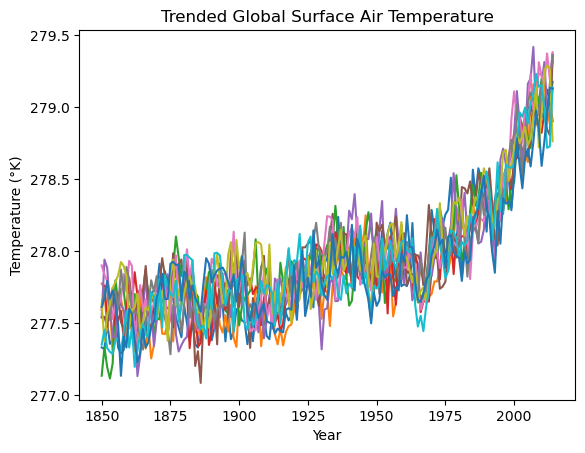

In [199]:
plt.figure()
plt.plot(tas_annual.year, tas_annual.T)
plt.title("Trended Global Surface Air Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature (°K)")
plt.show()

- This plot shows the raw, trended surface air temperature for each ensemble member from the CESM2 model. Each line represents one ensemble member’s global average temperature over time.
- This is your baseline: the original climate model output before any detrending. It captures the forced global warming trend that's shared across all members.

Plot all member time series: detrended

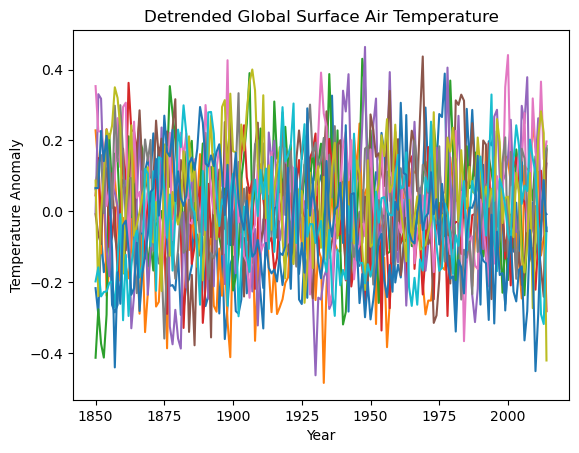

In [202]:
plt.figure()
plt.plot(detrended_members.year, detrended_members.T)
plt.title("Detrended Global Surface Air Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly")
plt.show()

- Each ensemble member now has the ensemble-mean trend removed. All members are roughly centered around 0.
- This plot highlights natural variability by removing the common climate change trend. It visually confirms that the trend was removed across space (members).

### **Compare Detrended vs Trended**
Now that we've calculated both the original (trended) and detrended temperature time series, we want to compare them on the same plot. But there's a problem: they're on different scales.

The original trended data shows absolute temperature values (in °K), while the detrended data has been centered around zero — it shows anomalies (changes from the average), not actual temperatures.

To make a fair comparison, we have two options:

__Method 1: Standardize the Trended Data__
- This means converting the original temperature values into anomalies, just like the detrended data.
- Standardization sets the mean to 0 and scales the variation by its standard deviation (mean=0, std=1).
- This puts both datasets on the same kind of scale: they now both show how much temperatures deviate from normal.
- This is useful if you want to compare patterns and timing, not exact temperature values

In [205]:
trended_mean = tas_annual.mean(dim='member')
trended_stand = (tas_annual.T - trended_mean.mean()) / trended_mean.std()

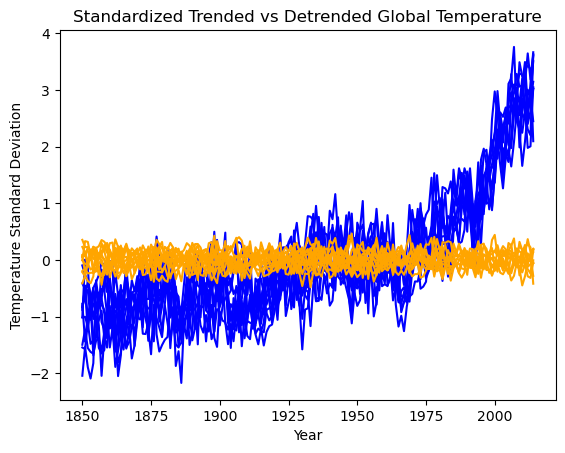

In [206]:
plt.figure()
plt.plot(trended_std.year, trended_stand, label='Trended (Standardized)', color='blue')
plt.plot(detrended_members.year, detrended_members.T, label='Detrended (Already Standardized)', color='orange')
plt.title("Standardized Trended vs Detrended Global Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature Standard Deviation")
plt.show()

- This overlays the ensemble-mean trend and detrended ensemble-mean on the same standrdized plot.
- You can clearly see the effect of detrending as you can compare it to the orignal trended data. The blue orginal trended data is stedly increasing and unlike the orange detrended series, which now fluctuates around zero.
- Having them side by side standardized shows how these two plots relate on the same scale and how much the warming trend plays a role in our global temperature rising when you compare it to the detrending basline which maintains its historical values throughout. 

__Method 2: Add back member baselines to detrended data__
Instead of changing the original data (like we do in Method 1), this method adjusts the detrended data to bring it back to the same scale as the original temperatures.

Here’s how it works:
- When we detrended the data earlier, we removed the shared warming trend and centered each member's time series around zero.
- But that also removed each member’s original temperature level (its baseline).
- Now, we add back each member's original average temperature — the long-term mean — to their detrended series.

__This shifts the detrended data back to the same °K range as the original data.__

Why do this?
- It keeps each member’s unique temperature range.
- It makes the plot easier to interpret because it’s back in real temperature units (°K), not just anomalies.
- This is useful if you care about absolute values, not just trends — for example, when comparing temperature levels across models or locations.

Compute the long-term average for each ensemble member over all years.
- This baseline is saved so that after detrending, you can restore each member's original temperature level (in °C) by adding it back.

In [210]:
mean_per_member = tas_annual.mean(dim='year')

Adds back each member’s mean to the detrended anomalies.
- `.expand_dims()` reshapes `mean_per_member` so it aligns correctly with detrended_members.

In [212]:
detrended_tas = detrended_members + mean_per_member.expand_dims({'year': tas_annual.year})

Plot restored °K values

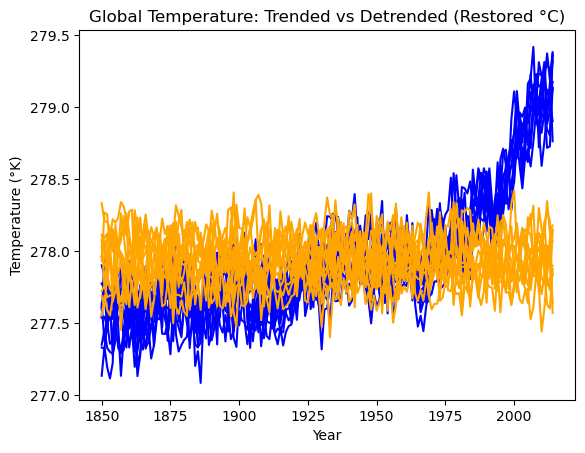

In [214]:
plt.figure()
plt.plot(tas_annual.year, tas_annual.T, label='Trended', color='blue')
plt.plot(detrended_tas.year, detrended_tas.T, label='Detrended', color='orange')
plt.title("Global Temperature: Trended vs Detrended (Restored °C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°K)")
plt.show()

- This overlays the ensemble-mean trend and detrended ensemble-mean on the same plot as well however instead of standardized you can see the temperature values along with it to get more context on how many degrees the trended data is rising above the detredned baseline.


This is end of tutorial thank you and I hope this helped !!!